### Exercise 1

We have 2 time series at once to predict, which are tied together. That means our neural network processes multidimensional data. A simple example would be to receive as an argument the past values of multiple stock market symbols in order to predict the future values of all those symbols with the neural network, which values are evolving together in time. That is what we will do in the exercise 6.

In [53]:
from datasets import generate_x_y_data_v1 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [54]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(10, 3, 2)
(10, 3, 2)
(seq_length, batch_size, output_dim)


#### Show Datasets
Display all batchs of the generated data.
The data contains two features which is combined with sine and cosine waves.

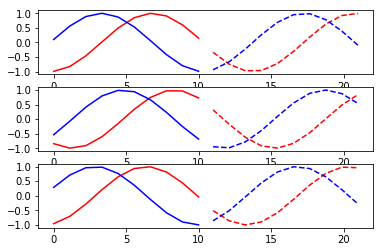

In [55]:
import math

plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
    plt.plot(x_axis+11, sample_y[:, i, 0], 'r--', x_axis+11, sample_y[:, i, 1], 'b--')

plt.show()

#### Test Encoder and Decoder
We import the encoder and decoder modules and test them to see whether it works. :)

In [56]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[1]
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 12  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 1

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 150
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [57]:
test_encoder = Encoder(input_dim, hidden_dim, number_of_layers=layers_stacked_count)

# initialize the hidden state(num_layers, batch_size, hidden_size).
hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))

sample_x, sample_y = generate_data(isTrain=True, batch_size=batch_size)
input_x = autograd.Variable(torch.FloatTensor(sample_x), requires_grad=False)

print(test_encoder)

Encoder (
  (encoder): LSTM(2, 12)
)


In [58]:
encoder_output, encoder_state = test_encoder(input_x,hidden)
print(encoder_output[-1])

Variable containing:

Columns 0 to 9 
 0.0826  0.1207  0.0096  0.1296 -0.1339  0.0951  0.1140  0.0336 -0.0245 -0.0346
 0.1286  0.1549 -0.0140  0.1079 -0.1672  0.1077  0.0839  0.0395 -0.0023 -0.0603
 0.1133  0.2779 -0.1001  0.0341 -0.2222  0.1575 -0.0366  0.0404  0.1722 -0.0995
-0.1680 -0.0130 -0.1080  0.1572  0.0859 -0.0106  0.0651 -0.0009 -0.0433  0.0361
 0.1290  0.2792 -0.0718  0.0341 -0.2323  0.1618 -0.0162  0.0505  0.1436 -0.0979

Columns 10 to 11 
-0.0697 -0.1169
-0.0729 -0.1398
-0.0243 -0.1423
-0.0621  0.0107
-0.0388 -0.1524
[torch.FloatTensor of size 5x12]



In [59]:
test_decoder = Decoder(hidden_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count)
print(test_decoder)

Decoder (
  (decoder): LSTM(12, 12)
  (linear): Linear (12 -> 2)
)


In [60]:
decoder_input = torch.unsqueeze(encoder_output[-1], 0)
print(decoder_input.size())
decoder_hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))
test_output, decoder_output, (next_ht, next_ct) = test_decoder(decoder_input, decoder_hidden)
print(next_ht.size())
print(next_ct.size())
print(decoder_output.size())
print(test_output)

torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
Variable containing:
-0.0397  0.0198
-0.3552  0.2104
-0.3348  0.0078
 0.1144 -0.0363
-0.0078  0.3094
[torch.FloatTensor of size 5x2]



#### Build a Seq2Seq Model
Combine the above encoder and decoder models to build a sequence to sequence model.
Train the model to predict the sine cosine wave dataset.

In [61]:
class Model(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 output_size,
                 number_of_layers=1,
                 output_length=10):
        super(Model, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, number_of_layers=number_of_layers)
        self.decoder = Decoder(hidden_size, hidden_size, output_size, number_of_layers=number_of_layers)
        self.output_length = output_length
        self.number_of_layers = number_of_layers
        self.hidden_size = hidden_size
        
    def forward(self, x):
        encoder_output, encoder_state = self.encoder(x, None)
        decoder_input = torch.unsqueeze(encoder_output[-1], 0)
        
        seq = []
        next_hidden=None
        next_input = decoder_input
        for _ in range(self.output_length):
            output, next_input, next_hidden = self.decoder(next_input, next_hidden)
            seq += [output]
        return torch.stack(seq, dim=0).squeeze()

In [62]:
model = Model(input_dim, hidden_dim, output_dim)
print(model)
test_output = model(input_x)
print(test_output.size())

Model (
  (encoder): Encoder (
    (encoder): LSTM(2, 12)
  )
  (decoder): Decoder (
    (decoder): LSTM(12, 12)
    (linear): Linear (12 -> 2)
  )
)
torch.Size([10, 5, 2])


Display predictions before training.


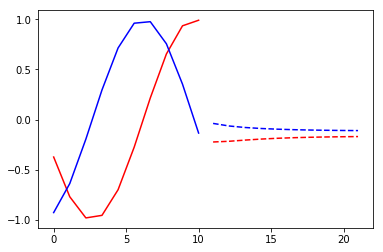

In [63]:
print('Display predictions before training.')
plot_y = test_output.data.numpy()
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
target_x = x_axis+11
plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
plt.show()

In [64]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
next_hidden = None

step: 0 , loss: 0.535321


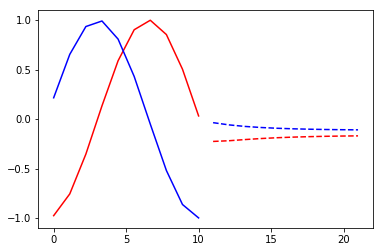

step: 50 , loss: 0.0808137


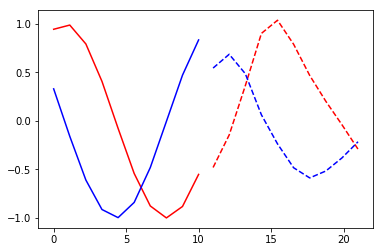

step: 100 , loss: 0.00429201


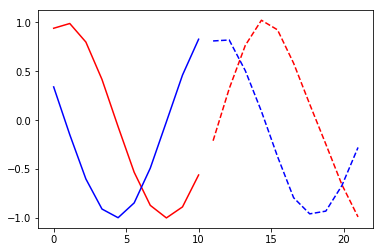

In [65]:
for step in range(nb_iters):
    temp_x, temp_y = generate_data(isTrain=True, batch_size=batch_size)
    x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
    y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
    optimizer.zero_grad()
    prediction = model(x)   # rnn output
    loss = loss_func(prediction, y)
    if step % 50 == 0:
        print('step:', step, ', loss:', loss.data.numpy()[0])
        plot_y = prediction.data.numpy()
        plt.figure()
        plt.yticks(np.linspace(-1,1,5))
        plt.plot(x_axis, temp_x[:, i, 0], 'r', x_axis, temp_x[:, i, 1], 'b')
        plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
        plt.show()
    loss.backward()
    optimizer.step()

In [66]:
temp_x, temp_y = generate_data(isTrain=False, batch_size=1)
x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
prediction = model(x)
prediction = prediction.data.numpy()
print(temp_x.shape)
print(prediction.shape)

(10, 1, 2)
(10, 2)


Display prediction after training.
The prediction is in yellow dashed lines with dots.
The ground truth is in blue dashed lines with cross marks.

Display prediction after training.


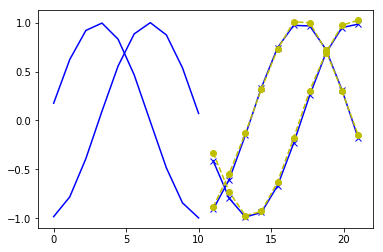

In [67]:
print('Display prediction after training.')
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, temp_x[:, 0, 0], 'b', x_axis, temp_x[:, 0, 1], 'b')
target_x = x_axis+11

plt.plot(target_x, temp_y[:, 0, 0], 'bx-', target_x, temp_y[:, 0, 1], 'bx-')
plt.plot(target_x, prediction[:, 0], 'yo--', target_x, prediction[:, 1], 'yo--')
plt.show()